In [17]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# Import your dataset and transforms
from dataset_creater import *
from torchsummary import summary
from torchaudio import transforms as T

In [18]:
# Set the path to your dataset
data_folder = "./data"
# transform = T.MelSpectrogram(sample_rate=44100, n_mels=64)
transform = T.MFCC(sample_rate=44100, n_mfcc=32)

# Create an instance of your dataset
dataset = AudioDataset(data_folder, transform=transform, scale=(-625, 195))

# Define the sizes of your splits
train_size = int(0.8 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Use random_split to create training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
# Move the training and validation data loaders to the selected device
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, shuffle=False)
test_loader = DataLoader(test_set, shuffle=False)


c:\Users\Sine\anaconda3\envs\pytorch\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [19]:
min_amplitude = np.inf
max_amplitude = -np.inf
for batch in train_loader:
    padded_waveforms, labels = batch
    # print("Padded waveforms shape:", padded_waveforms.shape)
    input_shape = padded_waveforms.shape[1:]
    if min_amplitude > padded_waveforms.min():
        min_amplitude = padded_waveforms.min()
    if max_amplitude < padded_waveforms.max():
        max_amplitude = padded_waveforms.max()
print(input_shape)
print("Min amplitude:", min_amplitude)
print("Max amplitude:", max_amplitude)

torch.Size([1, 32, 508])
Min amplitude: tensor(0.0004)
Max amplitude: tensor(1.0021)


In [20]:
class MelChordClassifier(nn.Module):
    def __init__(self):
        super(MelChordClassifier, self).__init__()
        # Define a CNN with input shape is (batch_size, 1, 128, 199) and output shape is (batch_size, 1)
        # it should reduce the dimensionality very quickly because the dataset is small (<1000)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(4,8), stride=1, padding=0) 
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(4,8), stride=(2, 4)) 

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(2,4), stride=1, padding=0) 
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=(2,4))

        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AdaptiveAvgPool2d((2,2))

        self.bn3 = nn.BatchNorm1d(32 * 2 * 2)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * 2 * 2, 32)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 1)
         # no activation function because we use BCEWithLogitsLoss

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1) # flatten
        x = self.bn3(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # Use BCEWithLogitsLoss instead of BCELoss because it combines a Sigmoid layer and the BCELoss in one single class
        # the output shape should be (batch_size,)
        return x.view(-1)

In [21]:


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model and move it to the selected device
model = MelChordClassifier().to(device)

# Instantiate loss function and move it to the selected device
criterion = nn.BCEWithLogitsLoss().to(device)

# Instantiate optimizer and move it to the selected device
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# output summary of model
summary(model, input_shape)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 29, 501]             264
       BatchNorm2d-2           [-1, 8, 29, 501]              16
              ReLU-3           [-1, 8, 29, 501]               0
         MaxPool2d-4           [-1, 8, 13, 124]               0
            Conv2d-5          [-1, 16, 12, 121]           1,040
       BatchNorm2d-6          [-1, 16, 12, 121]              32
              ReLU-7          [-1, 16, 12, 121]               0
         MaxPool2d-8            [-1, 16, 5, 30]               0
            Conv2d-9            [-1, 32, 2, 27]           8,224
             ReLU-10            [-1, 32, 2, 27]               0
AdaptiveAvgPool2d-11             [-1, 32, 2, 2]               0
      BatchNorm1d-12                  [-1, 128]             256
          Dropout-13                  [-1, 128]               0
           Linear-14                   

100%|██████████| 22/22 [00:03<00:00,  6.78it/s]


Training - Epoch 1/70, Loss: 0.7195, Accuracy: 0.5590
Validation - Epoch 1/70, Loss: 0.6883, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.10it/s]


Training - Epoch 2/70, Loss: 0.7061, Accuracy: 0.5779
Validation - Epoch 2/70, Loss: 0.7498, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


Training - Epoch 3/70, Loss: 0.6855, Accuracy: 0.5852
Validation - Epoch 3/70, Loss: 1.5110, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Training - Epoch 4/70, Loss: 0.6787, Accuracy: 0.5852
Validation - Epoch 4/70, Loss: 0.8361, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.23it/s]


Training - Epoch 5/70, Loss: 0.6712, Accuracy: 0.5939
Validation - Epoch 5/70, Loss: 0.7397, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.25it/s]


Training - Epoch 6/70, Loss: 0.6686, Accuracy: 0.6259
Validation - Epoch 6/70, Loss: 0.6866, Accuracy: 0.6471


100%|██████████| 22/22 [00:03<00:00,  7.26it/s]


Training - Epoch 7/70, Loss: 0.6723, Accuracy: 0.6012
Validation - Epoch 7/70, Loss: 0.6589, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.27it/s]


Training - Epoch 8/70, Loss: 0.6555, Accuracy: 0.6157
Validation - Epoch 8/70, Loss: 0.7133, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Training - Epoch 9/70, Loss: 0.6616, Accuracy: 0.6172
Validation - Epoch 9/70, Loss: 0.7780, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Training - Epoch 10/70, Loss: 0.6395, Accuracy: 0.6303
Validation - Epoch 10/70, Loss: 0.7483, Accuracy: 0.6118


100%|██████████| 22/22 [00:03<00:00,  7.24it/s]


Training - Epoch 11/70, Loss: 0.6605, Accuracy: 0.6143
Validation - Epoch 11/70, Loss: 0.6740, Accuracy: 0.6706


100%|██████████| 22/22 [00:03<00:00,  7.18it/s]


Training - Epoch 12/70, Loss: 0.6359, Accuracy: 0.6274
Validation - Epoch 12/70, Loss: 0.6324, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.11it/s]


Training - Epoch 13/70, Loss: 0.6307, Accuracy: 0.6346
Validation - Epoch 13/70, Loss: 0.6777, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.16it/s]


Training - Epoch 14/70, Loss: 0.6330, Accuracy: 0.6448
Validation - Epoch 14/70, Loss: 0.6729, Accuracy: 0.6235


100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Training - Epoch 15/70, Loss: 0.6295, Accuracy: 0.6390
Validation - Epoch 15/70, Loss: 0.7785, Accuracy: 0.5529


100%|██████████| 22/22 [00:03<00:00,  7.19it/s]


Training - Epoch 16/70, Loss: 0.6335, Accuracy: 0.6361
Validation - Epoch 16/70, Loss: 1.0568, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.27it/s]


Training - Epoch 17/70, Loss: 0.6231, Accuracy: 0.6463
Validation - Epoch 17/70, Loss: 0.7622, Accuracy: 0.5529


100%|██████████| 22/22 [00:03<00:00,  7.20it/s]


Training - Epoch 18/70, Loss: 0.6118, Accuracy: 0.6492
Validation - Epoch 18/70, Loss: 0.6853, Accuracy: 0.6471


100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


Training - Epoch 19/70, Loss: 0.6025, Accuracy: 0.6696
Validation - Epoch 19/70, Loss: 0.7997, Accuracy: 0.5882


100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


Training - Epoch 20/70, Loss: 0.6073, Accuracy: 0.6652
Validation - Epoch 20/70, Loss: 0.6803, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.22it/s]


Training - Epoch 21/70, Loss: 0.5912, Accuracy: 0.6448
Validation - Epoch 21/70, Loss: 0.7273, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  7.07it/s]


Training - Epoch 22/70, Loss: 0.5942, Accuracy: 0.6681
Validation - Epoch 22/70, Loss: 0.9422, Accuracy: 0.6588


100%|██████████| 22/22 [00:03<00:00,  6.88it/s]


Training - Epoch 23/70, Loss: 0.5842, Accuracy: 0.6638
Validation - Epoch 23/70, Loss: 0.8807, Accuracy: 0.5412


100%|██████████| 22/22 [00:03<00:00,  6.66it/s]


Training - Epoch 24/70, Loss: 0.5826, Accuracy: 0.6565
Validation - Epoch 24/70, Loss: 0.7044, Accuracy: 0.6235


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


Training - Epoch 25/70, Loss: 0.5820, Accuracy: 0.6856
Validation - Epoch 25/70, Loss: 0.8134, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  7.88it/s]


Training - Epoch 26/70, Loss: 0.5709, Accuracy: 0.6900
Validation - Epoch 26/70, Loss: 0.7488, Accuracy: 0.6118


100%|██████████| 22/22 [00:03<00:00,  6.60it/s]


Training - Epoch 27/70, Loss: 0.5612, Accuracy: 0.7103
Validation - Epoch 27/70, Loss: 1.0871, Accuracy: 0.4588


100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


Training - Epoch 28/70, Loss: 0.5723, Accuracy: 0.6827
Validation - Epoch 28/70, Loss: 0.8058, Accuracy: 0.6118


100%|██████████| 22/22 [00:02<00:00,  8.41it/s]


Training - Epoch 29/70, Loss: 0.5658, Accuracy: 0.6856
Validation - Epoch 29/70, Loss: 1.3142, Accuracy: 0.4235


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


Training - Epoch 30/70, Loss: 0.5775, Accuracy: 0.6914
Validation - Epoch 30/70, Loss: 1.7962, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  8.34it/s]


Training - Epoch 31/70, Loss: 0.5493, Accuracy: 0.7234
Validation - Epoch 31/70, Loss: 0.7380, Accuracy: 0.5882


100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


Training - Epoch 32/70, Loss: 0.5338, Accuracy: 0.7176
Validation - Epoch 32/70, Loss: 0.6706, Accuracy: 0.6824


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


Training - Epoch 33/70, Loss: 0.5390, Accuracy: 0.7031
Validation - Epoch 33/70, Loss: 0.7793, Accuracy: 0.5765


100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


Training - Epoch 34/70, Loss: 0.5331, Accuracy: 0.7336
Validation - Epoch 34/70, Loss: 0.7595, Accuracy: 0.6118


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


Training - Epoch 35/70, Loss: 0.5283, Accuracy: 0.7322
Validation - Epoch 35/70, Loss: 1.0179, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  8.41it/s]


Training - Epoch 36/70, Loss: 0.5316, Accuracy: 0.7336
Validation - Epoch 36/70, Loss: 0.7041, Accuracy: 0.6471


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


Training - Epoch 37/70, Loss: 0.5455, Accuracy: 0.7191
Validation - Epoch 37/70, Loss: 0.6557, Accuracy: 0.6706


100%|██████████| 22/22 [00:02<00:00,  8.27it/s]


Training - Epoch 38/70, Loss: 0.5194, Accuracy: 0.7176
Validation - Epoch 38/70, Loss: 0.8902, Accuracy: 0.5882


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


Training - Epoch 39/70, Loss: 0.5115, Accuracy: 0.7467
Validation - Epoch 39/70, Loss: 1.3372, Accuracy: 0.4353


100%|██████████| 22/22 [00:02<00:00,  8.29it/s]


Training - Epoch 40/70, Loss: 0.5041, Accuracy: 0.7424
Validation - Epoch 40/70, Loss: 0.8865, Accuracy: 0.5176


100%|██████████| 22/22 [00:02<00:00,  8.12it/s]


Training - Epoch 41/70, Loss: 0.4926, Accuracy: 0.7656
Validation - Epoch 41/70, Loss: 0.7965, Accuracy: 0.6118


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


Training - Epoch 42/70, Loss: 0.4764, Accuracy: 0.7802
Validation - Epoch 42/70, Loss: 0.6312, Accuracy: 0.6941


100%|██████████| 22/22 [00:02<00:00,  8.27it/s]


Training - Epoch 43/70, Loss: 0.4736, Accuracy: 0.7686
Validation - Epoch 43/70, Loss: 0.6575, Accuracy: 0.6941


100%|██████████| 22/22 [00:02<00:00,  7.94it/s]


Training - Epoch 44/70, Loss: 0.4769, Accuracy: 0.7584
Validation - Epoch 44/70, Loss: 1.0649, Accuracy: 0.5059


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


Training - Epoch 45/70, Loss: 0.4697, Accuracy: 0.7671
Validation - Epoch 45/70, Loss: 1.0895, Accuracy: 0.4118


100%|██████████| 22/22 [00:02<00:00,  8.29it/s]


Training - Epoch 46/70, Loss: 0.4605, Accuracy: 0.7875
Validation - Epoch 46/70, Loss: 2.6861, Accuracy: 0.3412


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


Training - Epoch 47/70, Loss: 0.4714, Accuracy: 0.7569
Validation - Epoch 47/70, Loss: 0.8909, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


Training - Epoch 48/70, Loss: 0.4523, Accuracy: 0.7846
Validation - Epoch 48/70, Loss: 1.4570, Accuracy: 0.4000


100%|██████████| 22/22 [00:02<00:00,  7.99it/s]


Training - Epoch 49/70, Loss: 0.4550, Accuracy: 0.8020
Validation - Epoch 49/70, Loss: 1.3323, Accuracy: 0.6471


100%|██████████| 22/22 [00:02<00:00,  7.96it/s]


Training - Epoch 50/70, Loss: 0.4572, Accuracy: 0.7773
Validation - Epoch 50/70, Loss: 2.0780, Accuracy: 0.6353


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


Training - Epoch 51/70, Loss: 0.4301, Accuracy: 0.8049
Validation - Epoch 51/70, Loss: 1.4496, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


Training - Epoch 52/70, Loss: 0.4343, Accuracy: 0.8064
Validation - Epoch 52/70, Loss: 1.0846, Accuracy: 0.4824


100%|██████████| 22/22 [00:02<00:00,  7.97it/s]


Training - Epoch 53/70, Loss: 0.4411, Accuracy: 0.8035
Validation - Epoch 53/70, Loss: 0.8507, Accuracy: 0.6000


100%|██████████| 22/22 [00:02<00:00,  7.82it/s]


Training - Epoch 54/70, Loss: 0.4276, Accuracy: 0.8079
Validation - Epoch 54/70, Loss: 1.2664, Accuracy: 0.6000


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


Training - Epoch 55/70, Loss: 0.4263, Accuracy: 0.8049
Validation - Epoch 55/70, Loss: 1.0581, Accuracy: 0.5765


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


Training - Epoch 56/70, Loss: 0.4085, Accuracy: 0.8239
Validation - Epoch 56/70, Loss: 3.5123, Accuracy: 0.3412


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


Training - Epoch 57/70, Loss: 0.3951, Accuracy: 0.8399
Validation - Epoch 57/70, Loss: 2.8510, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


Training - Epoch 58/70, Loss: 0.4062, Accuracy: 0.8137
Validation - Epoch 58/70, Loss: 1.5168, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  7.86it/s]


Training - Epoch 59/70, Loss: 0.3990, Accuracy: 0.8282
Validation - Epoch 59/70, Loss: 3.1466, Accuracy: 0.3529


100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


Training - Epoch 60/70, Loss: 0.3965, Accuracy: 0.8093
Validation - Epoch 60/70, Loss: 3.4827, Accuracy: 0.3412


100%|██████████| 22/22 [00:02<00:00,  7.83it/s]


Training - Epoch 61/70, Loss: 0.3805, Accuracy: 0.8326
Validation - Epoch 61/70, Loss: 0.9378, Accuracy: 0.5529


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


Training - Epoch 62/70, Loss: 0.3709, Accuracy: 0.8530
Validation - Epoch 62/70, Loss: 0.7785, Accuracy: 0.6588


100%|██████████| 22/22 [00:02<00:00,  7.85it/s]


Training - Epoch 63/70, Loss: 0.3591, Accuracy: 0.8399
Validation - Epoch 63/70, Loss: 1.0135, Accuracy: 0.6118


100%|██████████| 22/22 [00:02<00:00,  7.70it/s]


Training - Epoch 64/70, Loss: 0.3678, Accuracy: 0.8443
Validation - Epoch 64/70, Loss: 0.6806, Accuracy: 0.6824


100%|██████████| 22/22 [00:02<00:00,  7.88it/s]


Training - Epoch 65/70, Loss: 0.3620, Accuracy: 0.8472
Validation - Epoch 65/70, Loss: 1.0321, Accuracy: 0.5294


100%|██████████| 22/22 [00:02<00:00,  7.79it/s]


Training - Epoch 66/70, Loss: 0.3404, Accuracy: 0.8646
Validation - Epoch 66/70, Loss: 0.8647, Accuracy: 0.6706


100%|██████████| 22/22 [00:02<00:00,  7.88it/s]


Training - Epoch 67/70, Loss: 0.3323, Accuracy: 0.8806
Validation - Epoch 67/70, Loss: 1.8157, Accuracy: 0.6471


100%|██████████| 22/22 [00:02<00:00,  7.68it/s]


Training - Epoch 68/70, Loss: 0.3314, Accuracy: 0.8734
Validation - Epoch 68/70, Loss: 0.7709, Accuracy: 0.6471


100%|██████████| 22/22 [00:02<00:00,  7.91it/s]


Training - Epoch 69/70, Loss: 0.3146, Accuracy: 0.8879
Validation - Epoch 69/70, Loss: 1.1822, Accuracy: 0.5765


100%|██████████| 22/22 [00:02<00:00,  7.86it/s]


Training - Epoch 70/70, Loss: 0.3338, Accuracy: 0.8588
Validation - Epoch 70/70, Loss: 1.1192, Accuracy: 0.6353
Testing - Accuracy: 0.5287


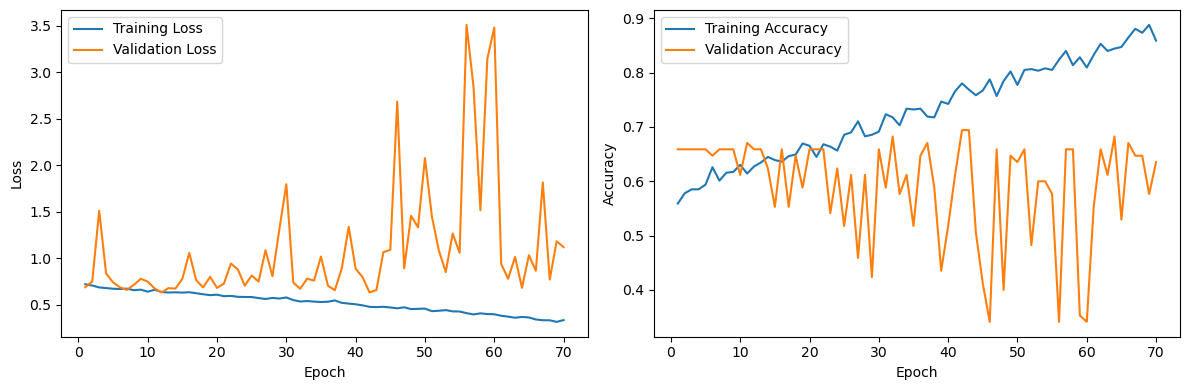

In [22]:
# Lists to store values for plotting
from cgi import test


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 70
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader):
        # convert labels to float because criterion requires float type labels
        labels = labels.type(torch.FloatTensor)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs > 0.5
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_labels = val_labels.type(torch.FloatTensor)
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs > 0.5
            val_correct += (val_predicted == val_labels).sum().item()
            val_samples += val_labels.size(0)

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {average_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_labels = test_labels.type(torch.FloatTensor)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5
        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Plot learning curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


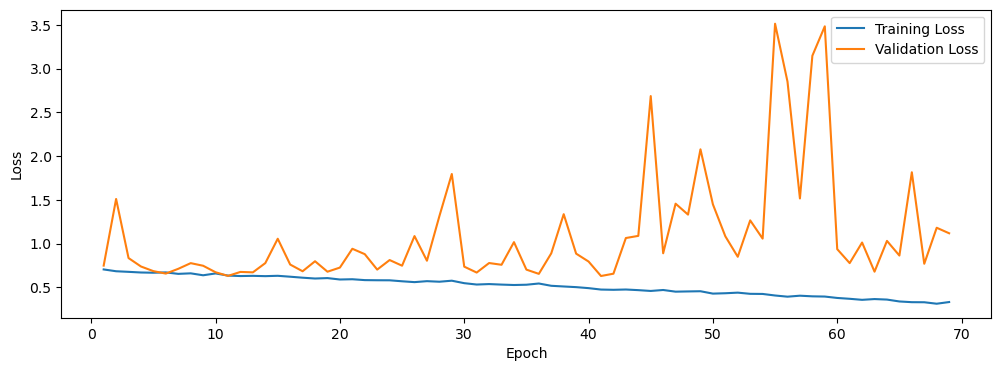

In [23]:
xrange = range(1, num_epochs)
plt.figure(figsize=(12, 4))
plt.plot(xrange, train_losses[1:], label='Training Loss')
plt.plot(xrange, val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Testing - Accuracy: 0.5287


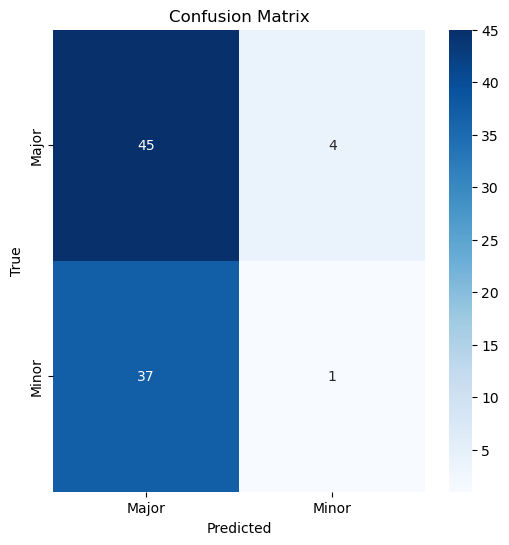

In [24]:
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Testing
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        test_predicted = test_outputs > 0.5

        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

        test_correct += (test_predicted == test_labels).sum().item()
        test_samples += test_labels.size(0)

test_accuracy = test_correct / test_samples
print(f'Testing - Accuracy: {test_accuracy:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Major', 'Minor']  # Modify based on your actual class names

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()